In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
image_folder = './Dataset/Images/Chest_X-Rays/' #path to folder containing images
df_path = './Chest_X-Rays_Reports.csv'
chexnet_weights = './CheXNet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [3]:
df = pd.read_csv(df_path)
print(df.shape)
print(df.columns.tolist())
df.head(2)

(4033, 11)
['image_1', 'image_2', 'comparison', 'indication', 'findings', 'impression', 'xml file name', 'im1_height', 'im1_width', 'im2_height', 'im2_width']


,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,none .,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x .,1.xml,624,512,420,512
1,CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png,chest radiographs,year old male chest pain .,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process .,10.xml,624,512,420,512


# Data Preprocessing

In [4]:
col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = ' ' + df.impression + ' '
df['impression_ip'] = ' ' + df.impression
df['impression_op'] = df.impression + ' ' 
print(df.shape)
df.head(2)

(4033, 7)


,image_1,image_2,impression,xml file name,impression_final,impression_ip,impression_op
0,./Dataset/Images/Chest_X-Rays/CXR1_1_IM-0001-3...,./Dataset/Images/Chest_X-Rays/CXR1_1_IM-0001-4...,normal chest x .,1.xml,normal chest x .,normal chest x .,normal chest x .
1,./Dataset/Images/Chest_X-Rays/CXR10_IM-0002-10...,./Dataset/Images/Chest_X-Rays/CXR10_IM-0002-20...,no acute cardiopulmonary process .,10.xml,no acute cardiopulmonary process .,no acute cardiopulmonary process .,no acute cardiopulmonary process .


In [5]:
df['impression'].value_counts() # Unique values counts

no acute cardiopulmonary abnormality .                                                                                        383
no acute cardiopulmonary findings .                                                                                           172
no acute cardiopulmonary disease .                                                                                            147
no acute cardiopulmonary abnormalities .                                                                                      141
no active disease .                                                                                                           137
                                                                                                                             ... 
no acute cardiopulmonary abnormality . no active disease .                                                                      1
scarring or pleural plaque in the left upper lobe with partial resection of the posterior 

Here we can see that some captions have only 1 values in the entire dataset while some datasets are having more than 5. What we will do here is that we will upsample all those datapoint which impression value counts <=5. First we will remove all those datapoints which are duplicated based on xml file name(ie of the same patient because some patients are having more than 2 images) and then split the data into train and test.

In [6]:
df.shape

(4033, 7)

In [7]:
df['xml file name'].unique()

array(['1.xml', '10.xml', '100.xml', ..., '997.xml', '998.xml', '999.xml'],
      dtype=object)

In [8]:
df['xml file name'].nunique()

3820

In [9]:
df['xml file name'].value_counts()

1303.xml    4
846.xml     3
2084.xml    3
3566.xml    3
3359.xml    3
           ..
224.xml     1
2240.xml    1
2241.xml    1
2242.xml    1
2806.xml    1
Name: xml file name, Length: 3820, dtype: int64

In [10]:
df.drop_duplicates(subset = ['xml file name'], inplace = True)

In [11]:
df.shape

(3820, 7)

In [12]:
df['xml file name'].nunique()

3820

In [13]:
df['xml file name'].value_counts()

1.xml       1
3415.xml    1
3404.xml    1
3405.xml    1
3406.xml    1
           ..
2209.xml    1
221.xml     1
2210.xml    1
2211.xml    1
999.xml     1
Name: xml file name, Length: 3820, dtype: int64

As we can see, the shape of the dataframe/dataset has changed.

In [14]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df['impression'].value_counts()
df = df.merge(k,
         left_on = 'impression',
         right_index=True) #join left impression value with right index

df.columns

Index(['impression', 'image_1', 'image_2', 'impression_x', 'xml file name',
       'impression_final', 'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [15]:
df.head(2)

,impression,image_1,image_2,impression_x,xml file name,impression_final,impression_ip,impression_op,impression_y
0,normal chest x .,./Dataset/Images/Chest_X-Rays/CXR1_1_IM-0001-3...,./Dataset/Images/Chest_X-Rays/CXR1_1_IM-0001-4...,normal chest x .,1.xml,normal chest x .,normal chest x .,normal chest x .,3
1274,normal chest x .,./Dataset/Images/Chest_X-Rays/CXR2145_IM-0766-...,./Dataset/Images/Chest_X-Rays/CXR2145_IM-0766-...,normal chest x .,2145.xml,normal chest x .,normal chest x .,normal chest x .,3


In [16]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] #changing the column names
del df['impression_x'] # deleting impression_x column
df.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,normal chest x .,./Dataset/Images/Chest_X-Rays/CXR1_1_IM-0001-3...,./Dataset/Images/Chest_X-Rays/CXR1_1_IM-0001-4...,1.xml,normal chest x .,normal chest x .,normal chest x .,3
1274,normal chest x .,./Dataset/Images/Chest_X-Rays/CXR2145_IM-0766-...,./Dataset/Images/Chest_X-Rays/CXR2145_IM-0766-...,2145.xml,normal chest x .,normal chest x .,normal chest x .,3
1732,normal chest x .,./Dataset/Images/Chest_X-Rays/CXR2545_IM-1054-...,./Dataset/Images/Chest_X-Rays/CXR2545_IM-1054-...,2545.xml,normal chest x .,normal chest x .,normal chest x .,3
1,no acute cardiopulmonary process .,./Dataset/Images/Chest_X-Rays/CXR10_IM-0002-10...,./Dataset/Images/Chest_X-Rays/CXR10_IM-0002-20...,10.xml,no acute cardiopulmonary process .,no acute cardiopulmonary process .,no acute cardiopulmonary process .,87
63,no acute cardiopulmonary process .,./Dataset/Images/Chest_X-Rays/CXR1051_IM-0039-...,./Dataset/Images/Chest_X-Rays/CXR1051_IM-0039-...,1051.xml,no acute cardiopulmonary process .,no acute cardiopulmonary process .,no acute cardiopulmonary process .,87


In [17]:
df.shape

(3820, 8)

# Train-Test Split

Here our approach is that, we will divide the data into two, one with all the impression value counts greater than 5 (say *other1*) and other being <=5 (say *other2*). Then split the data with test_size=0.1. A sample of 0.2*other2.shape[0] will be then taken and will be added on to the test data that was split. The other data from the other2 will be appended to train.

In [18]:
other1 = df[df['impression_counts']>5] #selecting those datapoints which have impression valuecounts >5
print('Shape of other1:',other1.shape)
other2 = df[df['impression_counts']<=5] #selecting those datapoints which have impression valuecounts <=5
print('Shape of other2:',other2.shape)

Shape of other1: (2013, 8)
Shape of other2: (1807, 8)


In [19]:
train,test = train_test_split(other1, stratify = other1['impression'].values, test_size = 0.1, random_state = 400)
print('Shape of initial train data:',train.shape)
print('Shape of initial test data:',test.shape)

Shape of initial train data: (1811, 8)
Shape of initial test data: (202, 8)


In [20]:
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 400) #getting some datapoints from other2 data for test data
print('Shape of 20% of other2 data(test data):',test_other2_sample.shape)

Shape of 20% of other2 data(test data): (361, 8)


In [21]:
other2 = other2.drop(test_other2_sample.index,axis=0) # getting remaining 80% for training
print('Shape of 80% of other2 data(adding to train data):',other2.shape)

Shape of 80% of other2 data(adding to train data): (1446, 8)


In [22]:
# here we will be choosing 0.2 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

In [23]:
train = train.append(other2) 
train = train.reset_index(drop=True)
print('Shape of final train data:',train.shape) # shape of initial train data + remaining 80% of other2
print('Shape of final test data:',test.shape) # shape of initial test data + 20% of other2

Shape of final train data: (3257, 8)
Shape of final test data: (563, 8)


# Upsampling-Downsampling

Now we will upsample and downsample certain datapoints.

In [24]:
train_df_majority = train[train['impression_counts']>=100] #having value counts >=100
train_df_minority = train[train['impression_counts']<=5] #having value counts <=5
train_df_other = train[(train['impression_counts']>5)&(train['impression_counts']<100)] #value counts between 5 and 100
n1 = train_df_minority.shape[0]
n2 = train_df_majority.shape[0]
n3 = train_df_other.shape[0]
print(f'n1, n2, n3: {n1}, {n2}, {n3}')
# we will upsample them to 30
df_minority_upsampled = resample(train_df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(train_df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(train_df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled, df_minority_upsampled, df_other_downsampled])
train = train.reset_index(drop=True)
del df_minority_upsampled, train_df_minority, train_df_majority, train_df_other, df_other_downsampled
print('\nShape of training dataset after up-downsampling:',train.shape)

n1, n2, n3: 1446, 934, 877

Shape of training dataset after up-downsampling: (4487, 8)


In [25]:
train.impression.value_counts()

comparison well expanded and clear lungs . mediastinal contour within normal limits . no acute cardiopulmonary abnormality identified .                                                                                                                                                                                               21
no acute cardiopulmonary abnormality .                                                                                                                                                                                                                                                                                                21
unremarkable radiographs of the chest .                                                                                                                                                                                                                                                                                               17
negative .   

In [26]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [27]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Creating Tokenizer

In [28]:
tokenizer = Tokenizer(filters = '', oov_token = '') # setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index[''] # tokened value of 
end_index = tokenizer.word_index[''] # tokened value of 

In [29]:
train.impression_final[0]

' no acute cardiopulmonary findings . '

In [30]:
train_captions[0]

[3, 6, 12, 32, 2]

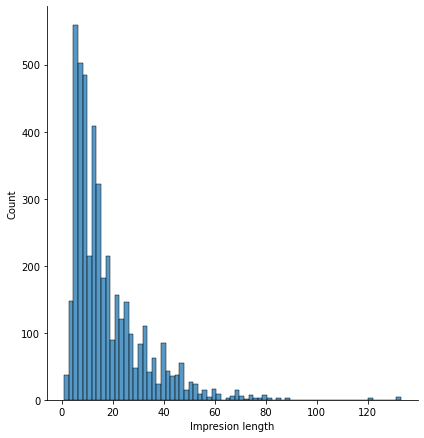


Value Counts for caption length top 5 values

Length|Counts
5     282
6     277
10    253
7     251
8     251
dtype: int64

The max and min value of "caption length" was found to be 133 and 1 respectively
The 80 percentile value of caption_len which is 27 will be taken as the maximum padded value for each impression


In [31]:
#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader